# Lab 5: Feature Engineering, Model Selection, and Overfitting

This lab will:

* Show you how linear regression can be used to model data that aren't "linear" through the process of **feature engineering**
* Show how conclusions about which model is best can be very different on the training set and the test set, which motivates the need for **model selection**
* Demonstrate the concept of **overfitting**, which is when a change to a model improves its performance on its training set at the expense of its performance on a test set.

Have fun!

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# Set some display settings.
sns.set(context='notebook')

# Defining a "plot" dataset

The concepts of feature engineering, model selection, and overfitting all apply to models with high dimensionality. But those models get hard to visualize. So instead we're going to take some made-up **1-dimensional** data, which will let us plot the model's predictions (even though those models will actually be using higher-dimensional transformations of the data).

We've done this plotting trick in past labs/hws by having a variable we called `x`. It was easy to get that `x` confused with the training and testing data, so for this lab we'll give it a special name: the "plot dataset". It will have the same *form* as our actual data (namely, a predictor called `x`), but it's totally made up just for the purposes of plotting.

We'll use 500 points on the so-called *unit interval* (0 to 1).

In [2]:
plot_dataset = pd.DataFrame({"x": np.linspace(0.0, 1.0, 500)})

# Make the data
Run this block of code to generate the datasets... but don't peek at its contents.

In [3]:
# RUN ME
if True:
                                                                                                                                                                           data = pd.DataFrame({"x": np.linspace(0., 1., 200)}); data['y'] = .5 + 1. * np.sin(3 * data['x']) + .25 * np.random.RandomState(0).standard_normal(len(data.x)); data = data.sample(frac=1., random_state=0); train = data.iloc[:50]; test = data.iloc[50:]; del data; train.to_csv('train.csv', index=False); test.to_csv('test.csv', index=False); del train; del test

# Load and visualize our data

Load up 'train.csv' (don't look at test.csv yet).

In [4]:
train = pd.read_csv('train.csv')
print(len(train), 'datapoints')
train.head()

50 datapoints


,x,y
0,0.090452,0.846306
1,0.854271,1.277217
2,0.537688,1.312243
3,0.492462,1.527369
4,0.889447,0.783395


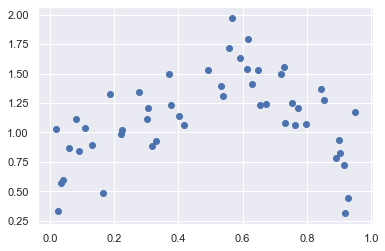

In [5]:
plt.scatter(train['x'], train['y'])

There seems to be some pattern to that data, but it might be pretty complicated. Let's try to model it!

# Linear model
First, try fitting a simple linear regression model to predict `y` from `x`.

1. **What MSE and R^2 does the linear regression model get** on the training data?
2. **Plot the training set points and the linear model on the same graph**.

In [6]:
def transform(data):
    return data[['x']]

train_X = transform(train)
train_y = train['y']

In [7]:
# Fit a linear regression
# Your code here.
linreg = LinearRegression().fit(train_X, train_y)

In [8]:
# Evaluate its performance. You may use the `metrics` module we imported above.
# Your code here.
train_y_pred = linreg.predict(train_X)
print("Training R^2:", metrics.r2_score(train_y, train_y_pred))
print("Training MSE:", metrics.mean_squared_error(train_y, train_y_pred))

Training R^2: 0.0405868946813569
Training MSE: 0.12786877954246


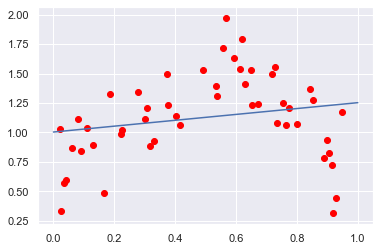

In [9]:
# Plot the training set points and the linear model
plt.scatter(train.x, train.y, color="red")

# Notice that we can use the same `transform` function on the plot dataset.
plot_X = transform(plot_dataset)

# your code here (to plot the linear model)
plot_y_pred = linreg.predict(plot_X)
plt.plot(plot_dataset.x, plot_y_pred)

# Piecewise linear approximation

Let's try modeling this data with a piecewise linear function. That is, the function doesn't have to be linear overall, but consists of gluing together linear "pieces".

There are a few ways of representing piecewise linear functions. One simple way is by representing them as a sum of "[rectifiers](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))". A *rectifier* is kind of like an absolute-value function, but instead of flipping negative values up to positive, it just chops them off (to zero) instead. These are widely used in deep neural networks these days; in this exercise you'll get a sense of how powerful these simple building blocks can be. A "rectified linear unit" (ReLU) is defined as:

$$\text{relu}(x) = \max(0, x)$$

Here's a rectifier. Try changing the `.5` to something else to see what happens.

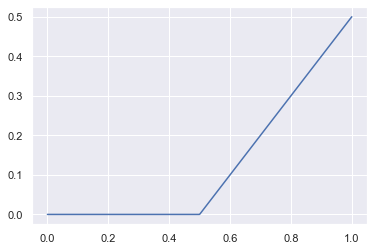

In [10]:
def relu(x):
    return np.maximum(0, x)

rectified_plot_x = relu(plot_dataset['x'] - .5)
plt.plot(plot_dataset['x'], rectified_plot_x)

It looks like data changes from going up to going down somewhere around 0.5. Let's make a rectifier with its zero point at 0.5 (like the one above) and try to use it to model our data.

The following code implements a predictive model that is *linear* in `x` and in `relu(x - .5)`. **Adjust the constants (except for 0.5) so that the model seems to roughly fit the data.**

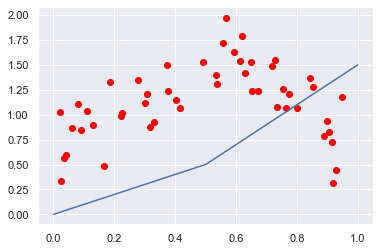

In [11]:
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x,
         0.0 + # intercept
         1.0 * plot_dataset.x + # linear term
         1.0 * relu(plot_dataset.x - 0.5) # rectifier term
        )

Notice that the rectifier term was just another `Series`. Rather than calculate it each time, we could have put it in as a column in our dataset, like we did with one-hot encoding in class and last week's lab. Let's do that using a `transform` function like we did in class:

In [12]:
def transform(data):
    X = data[['x']].copy()
    X['rectifier_1'] = relu(data['x'] - 0.5)
    return X

Let's use that transform function to redo the plot we just did. Copy your constants from above into this cell and verify that it makes the same plot.

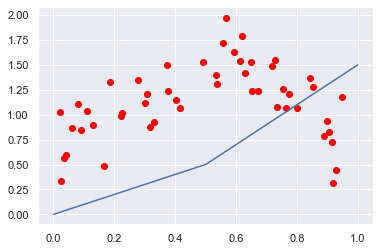

In [13]:
plot_X = transform(plot_dataset)
plt.scatter(train.x, train.y, color="red")

plt.plot(plot_dataset.x,
        0.0 + # intercept
        1.0 * plot_X['x'] + # linear term 
        1.0 * plot_X['rectifier_1']) # rectifier term

Now that we have a `transform` function, we can use `LinearRegression` to fit those constants for us instead:

In [14]:
train_X = transform(train)
train_y = train['y']
linreg = LinearRegression().fit(train_X, train_y)

Now, check that the coefficients it came up with are about the same as the ones you came up with:

In [15]:
linreg.intercept_

0.6091000318461095

In [16]:
linreg.coef_

array([ 2.01659631, -3.75927085])

And let's plot its predictions:

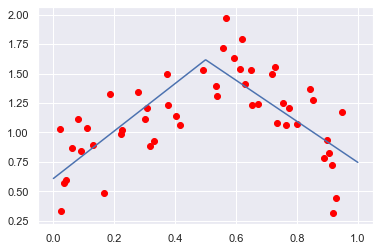

In [17]:
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)))

What MSE and R2 does this model get on the training set?

In [18]:
# your code here
metrics.mean_squared_error(train_y, linreg.predict(train_X))

0.06076589813761693

In [19]:
# your code here
metrics.r2_score(train_y, linreg.predict(train_X))

0.5440669783641089

Pause to answer a few questions:

1. How does the *shape* of the second model's prediction compare with the simple linear regression model you made first?
2. The prediction isn't a straight line. In what sense is the model's prediction still *linear*?
3. In what ways does the second model seem like a good fit for the data? How could it be better?
4. How do the MSE and R^2 numbers compare between the first and second models? (self-check: does that match your intuition? no response needed)

*your answer here*

# Improving the model
We added a predictor (in this case, a rectifier) and got a model that performed better on the training data. Let's add more predictors to try to get an even better fit!

## Step 1

Make a single cell that combines all of the steps we performed with the second model above:

1. transforms the data,
2. fits a linear regression,
3. prints out the training set R^2 and MSE, and
4. plots the training data and the model's predictions on the same plot.

**feel free to copy and paste your earlier code**

Training R^2: 0.5440669783641089
Training MSE: 0.06076589813761693


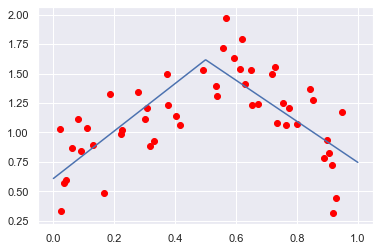

In [20]:
# your code here
# transform the data
def transform(data):
    X = data[['x']].copy()
    X['rectifier_1'] = relu(data['x'] - 0.5)
    return X
train_X = transform(train)
train_y = train['y']

# Fit a linreg
linreg = LinearRegression().fit(train_X, train_y)

# Eval performance
train_y_pred = linreg.predict(train_X)
print("Training R^2:", metrics.r2_score(train_y, train_y_pred))
print("Training MSE:", metrics.mean_squared_error(train_y, train_y_pred))

# Plot
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)));

## Step 2
Modify the `transform` function to add predictors to this model to try to improve its accuracy. *copy and paste your cell above* and modify it here.

Things you might try adding:

* more rectifiers
* polynomial terms ($x^2$, $x^3$ etc.)
* Periodic functions (`np.sin(2*np.pi * x)`, `np.sin(2*np.pi * 5 * x)`, `np.cos(2*np.pi * x)`, etc.)
* $\log(x+.1)$, $\exp$, ...

**See if you can get the R^2 to be above 0.75.** Feel free to write loops, etc.

*Note*: If you get tired of naming your new predictors, you can use this alternative version of `transform`.

```
def transform(data):
    x = data['x'].values
    predictors = [
        x,
        relu(x - .5), or whatever else here
    ]
    return np.stack(predictors, axis=1)
```

Training R^2: 0.7717540947510002
Training MSE: 0.03042018623464642


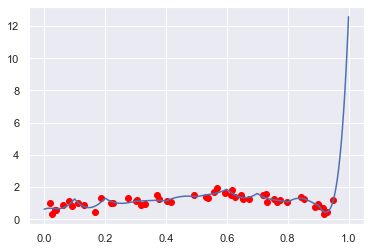

In [21]:
# your code here
# transform the data
def transform(data):
    x = data['x'].values
    predictors = [
        x,
    ]
    for i in range(2, 10):
        predictors.append(x ** i)
    for i in [.1, .2, .3, .4, .5, .6, .7, .8, .9]:
        predictors.append(relu(x - i))
    return np.stack(predictors, axis=1)

train_X = transform(train)
train_y = train['y']

# Fit a linreg
linreg = LinearRegression().fit(train_X, train_y)

# Eval performance
train_y_pred = linreg.predict(train_X)
print("Training R^2:", metrics.r2_score(train_y, train_y_pred))
print("Training MSE:", metrics.mean_squared_error(train_y, train_y_pred))

# Plot
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)));


# Generalization
Ok, we got a model that worked great! Now let's test it on some data it hasn't seen before. Load the test data!

In [22]:
test = pd.read_csv('test.csv')

Now let's make that plot and R^2 like above, but with the test data instead of the training data.

**Important**: *don't* re-fit the model here! Just use the `linreg` model from above.

Test R^2: -15.996834785808193


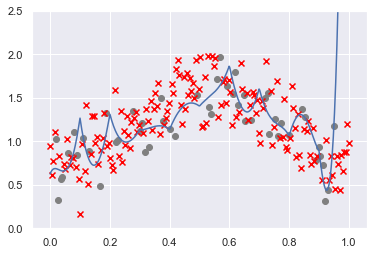

In [23]:
# your code here
test_X = transform(test)
test_y = test.y
plt.scatter(train.x, train.y, color='grey')
plt.scatter(test.x, test.y, color='red', marker='x')
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)))
plt.ylim([0.0, 2.5])
print("Test R^2:", metrics.r2_score(test_y, linreg.predict(test_X)))

1. What do you notice? 
2. Why do you think that happened?

*your answer here*

We **overfit**: we got a model that tracked the noise of the training set, so it found patterns that wouldn't possibly generalize to any other data.

Below here, copy and paste the `transform` function, but change it to the one you would now use.

Training R^2: 0.5440669783641089
Training MSE: 0.06076589813761693


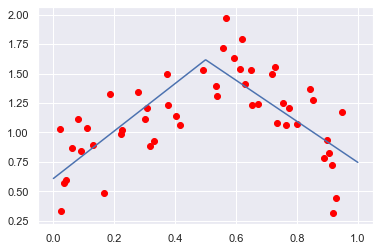

In [24]:
# your code here
def transform(data):
    x = data['x'].values
    predictors = [
        x,
        relu(x-.5)
    ]
    return np.stack(predictors, axis=1)

train_X = transform(train)
train_y = train['y']

# Fit a linreg
linreg = LinearRegression().fit(train_X, train_y)

# Eval performance
train_y_pred = linreg.predict(train_X)
print("Training R^2:", metrics.r2_score(train_y, train_y_pred))
print("Training MSE:", metrics.mean_squared_error(train_y, train_y_pred))

# Plot
plt.scatter(train.x, train.y, color="red")
plt.plot(plot_dataset.x, linreg.predict(transform(plot_dataset)));


Why did you include those predictors?

*your answer here*

The only trend I'm really confident that the data has is a general up-then-down trend. The single added relu feature captures only that, no more.

What are some things we could have *done* or *observed* that would have helped us realize that we were going to do so badly on unseen data *before* looking at the test set? How would these things have helped?

*your answer here*

We could have *held out* a **validation set** to see how well our model generalizes to that.